# Setup

## Modules

In [1]:
from statsmodels.formula.api import ols
import numpy as np
import pandas as pd
import HTfunctions as ht
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import stats
import geopandas as gpd
import descartes
from shapely.geometry import Point,Polygon
import itertools
import random
from matplotlib.lines import Line2D
import seaborn as sns

## Importing data

In [2]:
file = ht.findFiles("*Mag*snowmelt_*ost*1983*","Results/Daily")[0]
print(file)
snowmelt = np.load(file)

file = ht.findFiles("*Mag*rainfall_*ost*1983*","Results/Daily")[0]
print(file)
rainfall = np.load(file)

file = ht.findFiles("*Mag*_stream*ost*1983*","Results/Daily")[0]
print(file)
streamflow = np.load(file)

file = ht.findFiles("*Mag*temp*ost*1983*","Results/Daily")[0]
print(file)
temperature = np.load(file)

Results/Daily/trendMagnitudes_snowmelt_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfall_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_streamflow_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_temperature_ost_10dMA_1983_2012.npy


In [3]:
# checking that trend arrays are all same shape
print(snowmelt.shape)
print(rainfall.shape)
print(streamflow.shape)
print(temperature.shape)

(51, 365)
(51, 365)
(51, 365)
(51, 365)


In [4]:
q_1 = np.roll(streamflow,-1,axis=1)
streamflow[0,0:10]
q_1[0,0:10]

array([-0.00702649, -0.00764654, -0.00842806, -0.00884884, -0.00781402,
       -0.00825735, -0.00857362, -0.00910024, -0.00879364, -0.00886777])

In [5]:
# getting the snumbers of the catchments
final = ht.openDict("Data/finalSelectionList.pkl")
catchments = final["ost"]["1983-2012"]
# checking that the list is correct length
len(catchments)

51

In [6]:
meta = pd.read_csv("Data/newFinalSelection_1983_2012.csv",index_col=0)

## Quality functions

In [7]:
def rmse(mod,obs):
    out = np.sqrt(((mod-obs)**2).mean())
    return out

def nse(mod,obs):
    out = 1 - (((mod-obs)**2).sum()/((obs-obs.mean())**2).sum())
    return out

# Multiple regression (streamflow, snowmelt, rainfall trends)

## Testing two vs. three independent variables

In [69]:
c = 13 #selecting a single catchment

### Two independent variables / predictots

#### Unadjusted trends

(365,)
(365,)
(365,)


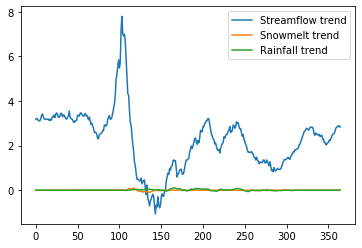

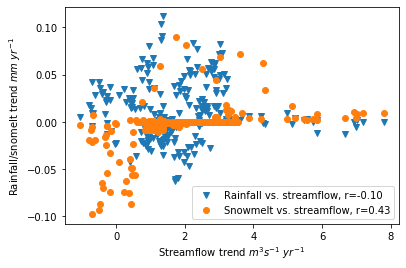

In [70]:
lag = 0
snow = snowmelt[c,:-lag]
rain = rainfall[c,:-lag]
stream = streamflow[c,lag:]

if lag==0:
    snow = snowmelt[c,:]
    rain = rainfall[c,:]
    stream = streamflow[c,:]

# adding lag removes some datapoints
print(snow.shape)
print(rain.shape)
print(stream.shape)

plt.plot(stream,label="Streamflow trend")
plt.plot(snow,label="Snowmelt trend")
plt.plot(rain,label="Rainfall trend")
plt.legend()

plt.figure()
plt.plot(stream,rain,"v",label=f"Rainfall vs. streamflow, r={stats.pearsonr(stream,rain)[0]:.2f}")
plt.plot(stream,snow,"o",label=f"Snowmelt vs. streamflow, r={stats.pearsonr(stream,snow)[0]:.2f}")
plt.xlabel("Streamflow trend $m^3 s^{-1} \ yr^{-1}$")
plt.ylabel("Rainfall/snomelt trend $mm \ yr^{-1}$")
plt.legend()

In [71]:
# linear model with two independent variables
data = pd.DataFrame({'x1': snow, 'x2': rain, 'y': stream})

model = ols("y ~ x1 + x2", data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     41.37
Date:                Tue, 14 Jan 2020   Prob (F-statistic):           6.59e-17
Time:                        14:56:13   Log-Likelihood:                -589.99
No. Observations:                 365   AIC:                             1186.
Df Residuals:                     362   BIC:                             1198.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3223      0.067     34.747      0.0

R-squared(adj):	 0.26410395749794646
RMSE:		 0.2570948287661512
NSE:		 0.268147342346859
Model parameters:
Intercept    0.292956
x1           6.985890
x2           3.976079
dtype: float64


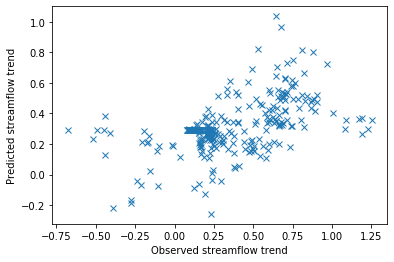

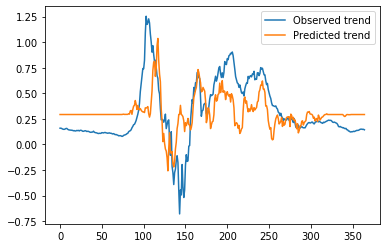

In [10]:
pred = model.predict()
plt.plot(stream,pred,"x")
plt.xlabel("Observed streamflow trend")
plt.ylabel("Predicted streamflow trend")

plt.figure()
plt.plot(stream,label = "Observed trend")
plt.plot(pred,label="Predicted trend")
plt.legend()

print("R-squared(adj):\t",model.rsquared_adj)
print("RMSE:\t\t",rmse(pred,stream))
print("NSE:\t\t",nse(pred,stream))
print(f"Model parameters:\n{model.params}")


#### Post-analysis filtered trends
Attempting to improve regression through smoothing the calculated trends with a MA filter (post-analysis).

In [11]:
def moving_average(x, w):
    """
    https://stackoverflow.com/a/54628145
    """
    return np.convolve(x, np.ones(w), 'valid') / w

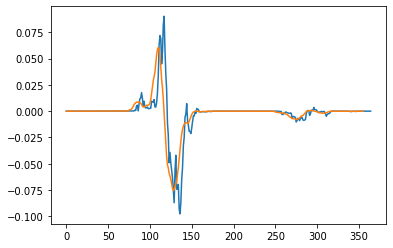

In [12]:
smooth = moving_average(snow,10)
plt.plot(snow)
plt.plot(smooth)

In [13]:
MA = 5

# linear model with two independent variables
data = pd.DataFrame({'x1': moving_average(snow,MA), 
                     'x2': moving_average(rain,MA), 
                     'y': moving_average(stream,MA)})

model = ols("y ~ x1 + x2", data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     78.15
Date:                Tue, 17 Dec 2019   Prob (F-statistic):           6.89e-29
Time:                        13:34:59   Log-Likelihood:                -7.4703
No. Observations:                 361   AIC:                             20.94
Df Residuals:                     358   BIC:                             32.61
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2920      0.014     21.278      0.0

R-squared(adj):	 0.30000899708975837
RMSE:		 0.24703004458132607
NSE:		 0.30389783599481535
Model parameters:
Intercept    0.292041
x1           7.745268
x2           4.507368
dtype: float64


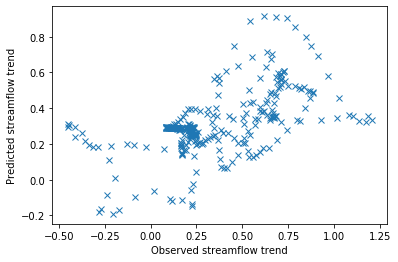

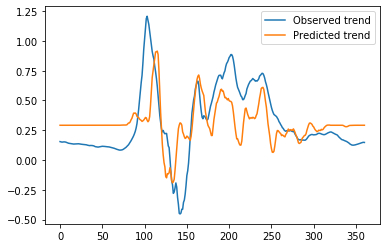

In [14]:
pred = model.predict()
plt.plot(moving_average(stream,MA),pred,"x")
plt.xlabel("Observed streamflow trend")
plt.ylabel("Predicted streamflow trend")

plt.figure()
plt.plot(moving_average(stream,MA),label = "Observed trend")
plt.plot(pred,label="Predicted trend")
plt.legend()

print("R-squared(adj):\t",model.rsquared_adj)
print("RMSE:\t\t",rmse(pred,moving_average(stream,MA)))
print("NSE:\t\t",nse(pred,moving_average(stream,MA)))
print(f"Model parameters:\n{model.params}")


### Three predictors

(365,)
(365,)
(365,)
(365,)


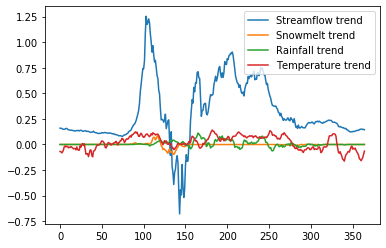

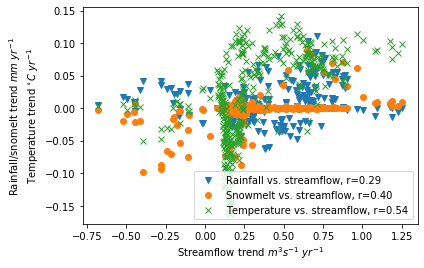

In [15]:
snow = snowmelt[c,:]
rain = rainfall[c,:]
stream = streamflow[c,:]
temp = temperature[c,:]

# adding lag removes some datapoints
print(snow.shape)
print(rain.shape)
print(stream.shape)
print(temp.shape)

plt.plot(stream,label="Streamflow trend")
plt.plot(snow,label="Snowmelt trend")
plt.plot(rain,label="Rainfall trend")
plt.plot(temp,label="Temperature trend")
plt.legend()

plt.figure()
plt.plot(stream,rain,"v",label=f"Rainfall vs. streamflow, r={stats.pearsonr(stream,rain)[0]:.2f}")
plt.plot(stream,snow,"o",label=f"Snowmelt vs. streamflow, r={stats.pearsonr(stream,snow)[0]:.2f}")
plt.plot(stream,temp,"x",label=f"Temperature vs. streamflow, r={stats.pearsonr(stream,temp)[0]:.2f}")
plt.xlabel("Streamflow trend $m^3 s^{-1} \ yr^{-1}$")
plt.ylabel("Rainfall/snomelt trend $mm \ yr^{-1}$\nTemperature trend $^{\circ}C \ yr^{-1}$")
plt.legend()

In [16]:
# linear model with two independent variables
data = pd.DataFrame({'x1': snow, 
                     'x2': rain,
                     'x3':temp,
                     'y': stream})

model = ols("y ~ x1 + x2 + x3", data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     104.8
Date:                Tue, 17 Dec 2019   Prob (F-statistic):           8.47e-49
Time:                        13:35:00   Log-Likelihood:                 35.183
No. Observations:                 365   AIC:                            -62.37
Df Residuals:                     361   BIC:                            -46.77
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2531      0.013     20.162      0.0

R-squared(adj):	 0.4609454467877482
RMSE:		 0.21973578149617815
NSE:		 0.4653882040944427
Model parameters:
Intercept    0.253131
x1           5.282866
x2           3.581521
x3           2.071946
dtype: float64


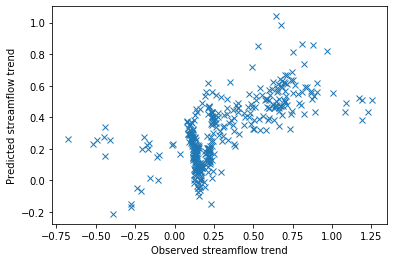

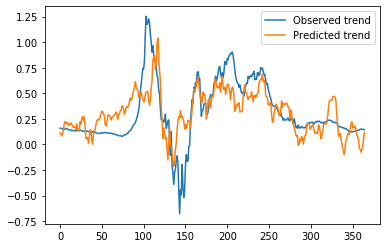

In [17]:
pred = model.predict()
plt.plot(stream,pred,"x")
plt.xlabel("Observed streamflow trend")
plt.ylabel("Predicted streamflow trend")

plt.figure()
plt.plot(stream,label = "Observed trend")
plt.plot(pred,label="Predicted trend")
plt.legend()

print("R-squared(adj):\t",model.rsquared_adj)
print("RMSE:\t\t",rmse(pred,stream))
print("NSE:\t\t",nse(pred,stream))
print(f"Model parameters:\n{model.params}")


### Comments
* It appears that multiple regression using both snowmelt and rainfall trend as independent variables can predict the streamflow trend well in many catchments, but not all.
* Trying to remove the lag between snowmelt/rainfall and streamflow did not appear to affect the results
* Adding temperature trend as a predictor may improve results

## All catchments

Calculating the correlation between streamflow trend and snowmelt and rainfall trend for all catchments (separately). 

In [8]:
def OLSregionArray(streamflow,snowmelt,rainfall,catchments,addTemp=False,temperature=None):
    """
    OLS regression on daily streamflow, snowmelt and rainfall trends.
    Streamflow as dependent variable y, snowmelt and rainfall as indepenent variables x1,x2:
    y ~ x1 + x2
    
    Parameters
    ----------
    streamflow: numpy.array
    snowmelt: numpy.array
    rainfall:numpy.array
    catchments: list
    lag: int
        default: 0
        as the streamflow trends often lag behind the other two,
        the lag parameter will shift the streamflow timeseries relative to the others
    
    Returns
    -------
    results: dictionary 
        with results from all catchments, with snumber of catchments as keys
        each results[snumber] is a dictionary containing:
            "summary": str
                a model summary that can be printed
            "observed_qtrend": numpy.array
                the observed streamflow trend in that catchment
            "modelled_qtrend": numpy.array
                the streamflow trend predicted by the model
            "model": statsmodels.regression.linear_model.RegressionResultsWrapper
                the linear regression model
    """
    
    results = {}

    for c in range(streamflow.shape[0]):
        # getting the snumber of catchment
        snumber = catchments[c]

        # creating an empty dictionary with snumber as key
        results[snumber] = {}

        # modelling
        # adjusting for lag between snowmelt/rainfall and streamflow trends
        snow = snowmelt[c,:]
        rain = rainfall[c,:]
        stream = streamflow[c,:]
        results[snumber]["observed_qtrend"] = stream
        if addTemp:
            temp = temperature[c,:]

        # linear model with two independent variables
        data = pd.DataFrame({'x1': snow, 'x2': rain, 'y': stream})
        model = ols("y ~ x1 + x2", data).fit()
        results[snumber]["model"] = model
        # with three independent variables
        if addTemp:
            data = pd.DataFrame({'x1': snow, 
                                 'x2': rain,
                                 'x3':temp,
                                 'y': stream})
            model = ols("y ~ x1 + x2 + x3", data).fit()
            results[snumber]["model"] = model

        # model summary as string
        results[snumber]["summary"] = str(model.summary())

        # predictions of the model
        results[snumber]["modelled_qtrend"] = model.predict()
        
        # correlation between all variables
        results[snumber]["corr"] = data.corr()
    
    return results

def OLSresultsToDataFrame(results,temp=False,splitSeason=False):
    d = {}
    for c in catchments:
        d[c] = {}
        d[c]["rsquared_adj"] = results[c]["model"].rsquared_adj
        d[c]["aic"] = results[c]["model"].aic
        obs = results[c]["observed_qtrend"]
        mod = results[c]["modelled_qtrend"]
        d[c]["rmse"] = rmse(mod,obs)
        d[c]["nse"] = nse(mod,obs)
        if splitSeason:
            for season in ["spring","summer","autumn","winter"]:
                m = ht.splitBySeason(mod,season)
                o = ht.splitBySeason(obs,season)
                d[c][f"rmse_{season}"] = rmse(m,o)
                d[c][f"nse_{season}"] = nse(m,o)
        d[c]["intercept"] = results[c]["model"].params.Intercept
        d[c]["x1_snow"] = results[c]["model"].params.x1
        d[c]["x2_rain"] = results[c]["model"].params.x2
        if temp:
            d[c]["x3_temp"] = results[c]["model"].params.x3
    df = pd.DataFrame.from_dict(d,orient="index")
    df.index.name = "snumber"
    return df

def plotOLSresults(results,catchments,region,period,temp=False):
    for c in catchments:
        obs = results[c]["observed_qtrend"]
        mod = results[c]["modelled_qtrend"]
        params = results[c]['model'].params
        
        fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
        ax[1].plot(obs,mod,"xk")
        ax[1].set_xlabel("Observed streamflow trend")
        ax[1].set_ylabel("Predicted streamflow trend")
        ax[1].set_title(f"$R^2(adj) =$  {results[c]['model'].rsquared_adj:.3}" ,loc="left")

        ax[0].plot(obs,label="Observed streamflow trend")
        ax[0].plot(mod,label="Predicted streamflow trend")
        ax[0].legend()
        ax[0].set_xlabel("Day of year")
        ax[0].set_ylabel("Streamflow trend $m^3 s^{-1} \ yr^{-1}$")
        
        if temp:
            ax[0].set_title(f"Qtrend = {params.Intercept:.2} + {params.x1:.2} SMtrend + {params.x2:.2} RFtrend + {params.x3:.2} Ttrend",
                            loc="left")
        else:
            ax[0].set_title(f"Qtrend = {params.Intercept:.2} + {params.x1:.2} SMtrend + {params.x2:.2} RFtrend",
                            loc="left")

        if temp:
            plt.savefig(f"Plots/1983_2012/OLS/Individual_catchments/OLS_Qtrends_QSMRFT_{c}_{region}_{period}.png",dpi=200)
        else:
            plt.savefig(f"Plots/1983_2012/OLS/Individual_catchments/OLS_Qtrends_QSMRF_{c}_{region}_{period}.png",dpi=200)
        plt.close()

In [15]:
test = OLSregionArray(streamflow,snowmelt,rainfall,catchments,addTemp=True,temperature=temperature)

In [16]:
print(test[list(test.keys())[0]]["summary"])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     26.86
Date:                Fri, 06 Mar 2020   Prob (F-statistic):           1.06e-15
Time:                        12:08:23   Log-Likelihood:                 140.63
No. Observations:                 365   AIC:                            -273.3
Df Residuals:                     361   BIC:                            -257.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0049      0.010     -0.486      0.6

Text(0, 0.5, 'Streamflow trend $m^3 s^{-1} \\ yr^{-1}$')

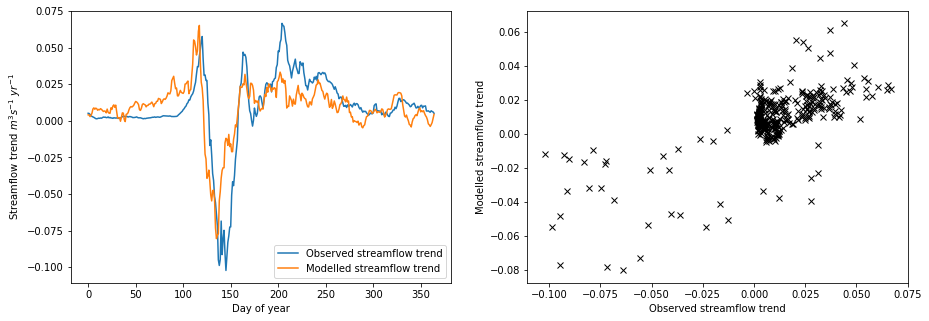

In [17]:
c = catchments[13]
obs = test[c]["observed_qtrend"]
mod = test[c]["modelled_qtrend"]

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
ax[1].plot(obs,mod,"xk")
ax[1].set_xlabel("Observed streamflow trend")
ax[1].set_ylabel("Modelled streamflow trend")

ax[0].plot(obs,label="Observed streamflow trend")
ax[0].plot(mod,label="Modelled streamflow trend")
ax[0].legend()
ax[0].set_xlabel("Day of year")
ax[0].set_ylabel("Streamflow trend $m^3 s^{-1} \ yr^{-1}$")


In [22]:
df = OLSresultsToDataFrame(test)
test[c]["model"].aic
#df.aic

-1866.8001440078915

### Vestlandet

In [23]:
region = "vest"
catchments = final[region]["1983-2012"]

file = ht.findFiles(f"*Mag*snowmelt_*{region}*1983*","Results/Daily")[0]
print(file)
snowmelt = np.load(file)

file = ht.findFiles(f"*Mag*rainfall_*{region}*1983*","Results/Daily")[0]
print(file)
rainfall = np.load(file)

file = ht.findFiles(f"*Mag*_stream*{region}*1983*","Results/Daily")[0]
print(file)
streamflow = np.load(file)

file = ht.findFiles(f"*Mag*temp*{region}*1983*","Results/Daily")[0]
print(file)
temperature = np.load(file)

# with T
results = OLSregionArray(streamflow,snowmelt,rainfall,catchments)
ht.saveDict(results,f"Results/OLS/multiregression_QSMRF_{region}_1983_2012")
df = OLSresultsToDataFrame(results)
df.to_csv(f"Results/OLS/multiregression_QSMRF_{region}_1983_2012_annual.csv")
#plotOLSresults(results, catchments, region, "1983_2012")

# without T
results = OLSregionArray(streamflow,snowmelt,rainfall,catchments,addTemp=True,temperature=temperature)
ht.saveDict(results,f"Results/OLS/multiregression_QSMRFT_{region}_1983_2012")
df = OLSresultsToDataFrame(results,temp=True)
print(df.aic)
df.to_csv(f"Results/OLS/multiregression_QSMRFT_{region}_1983_2012_annual.csv")
#plotOLSresults(results, catchments, region, "1983_2012",temp=True)

Results/Daily/trendMagnitudes_snowmelt_vest_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfall_vest_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_streamflow_vest_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_temperature_vest_10dMA_1983_2012.npy
snumber
7600005     -712.859879
4600009    -2216.345016
7500022     -664.002368
10900009    -368.234463
8800004     -347.047087
               ...     
10500001    -664.570625
10100001   -1604.891391
10700003   -2507.270778
8100001    -3017.262288
3900001    -3764.484150
Name: aic, Length: 61, dtype: float64


### Østlandet

In [24]:
region = "ost"
catchments = final[region]["1983-2012"]

file = ht.findFiles(f"*Mag*snowmelt_*{region}*1983*","Results/Daily")[0]
print(file)
snowmelt = np.load(file)

file = ht.findFiles(f"*Mag*rainfall_*{region}*1983*","Results/Daily")[0]
print(file)
rainfall = np.load(file)

file = ht.findFiles(f"*Mag*_stream*{region}*1983*","Results/Daily")[0]
print(file)
streamflow = np.load(file)

file = ht.findFiles(f"*Mag*temp*{region}*1983*","Results/Daily")[0]
print(file)
temperature = np.load(file)

results = OLSregionArray(streamflow,snowmelt,rainfall,catchments)
ht.saveDict(results,f"Results/OLS/multiregression_QSMRF_{region}_1983_2012")
df = OLSresultsToDataFrame(results)
df.to_csv(f"Results/OLS/multiregression_QSMRF_{region}_1983_2012_annual.csv")
#plotOLSresults(results, catchments, region, "1983_2012")

results = OLSregionArray(streamflow,snowmelt,rainfall,catchments,addTemp=True,temperature=temperature)
ht.saveDict(results,f"Results/OLS/multiregression_QSMRFT_{region}_1983_2012")
df = OLSresultsToDataFrame(results,temp=True)
df.to_csv(f"Results/OLS/multiregression_QSMRFT_{region}_1983_2012_annual.csv")
#plotOLSresults(results, catchments, region, "1983_2012",temp=True)

Results/Daily/trendMagnitudes_snowmelt_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfall_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_streamflow_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_temperature_ost_10dMA_1983_2012.npy


### Nordland

In [72]:
region = "nord"
catchments = final[region]["1983-2012"]

file = ht.findFiles(f"*Mag*snowmelt_*{region}*1983*","Results/Daily")[0]
print(file)
snowmelt = np.load(file)

file = ht.findFiles(f"*Mag*rainfall_*{region}*1983*","Results/Daily")[0]
print(file)
rainfall = np.load(file)

file = ht.findFiles(f"*Mag*stream*{region}*1983*","Results/Daily")[0]
print(file)
streamflow = np.load(file)

file = ht.findFiles(f"*Mag*temp*{region}*1983*","Results/Daily")[0]
print(file)
temperature = np.load(file)

results = OLSregionArray(streamflow,snowmelt,rainfall,catchments)
ht.saveDict(results,f"Results/OLS/multiregression_QSMRF_{region}_1983_2012")
df = OLSresultsToDataFrame(results)
df.to_csv(f"Results/OLS/multiregression_QSMRF_{region}_1983_2012.csv")
#plotOLSresults(results, catchments, region, "1983_2012")

results = OLSregionArray(streamflow,snowmelt,rainfall,catchments,addTemp=True,temperature=temperature)
ht.saveDict(results,f"Results/OLS/multiregression_QSMRFT_{region}_1983_2012")
df = OLSresultsToDataFrame(results,temp=True)
df.to_csv(f"Results/OLS/multiregression_QSMRFT_{region}_1983_2012.csv")
#plotOLSresults(results, catchments, region, "1983_2012",temp=True)

Results/Daily/trendMagnitudes_snowmelt_nord_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfall_nord_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_streamflow_nord_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_temperature_nord_10dMA_1983_2012.npy


### Trøndelag

In [77]:
region = "trond"
catchments = final[region]["1983-2012"]

file = ht.findFiles(f"*Mag*snowmelt_*{region}*1983*","Results/Daily")[0]
print(file)
snowmelt = np.load(file)

file = ht.findFiles(f"*Mag*rainfall_*{region}*1983*","Results/Daily")[0]
print(file)
rainfall = np.load(file)

file = ht.findFiles(f"*Mag*stream*{region}*1983*","Results/Daily")[0]
print(file)
streamflow = np.load(file)

file = ht.findFiles(f"*Mag*temp*{region}*1983*","Results/Daily")[0]
print(file)
temperature = np.load(file)

results = OLSregionArray(streamflow,snowmelt,rainfall,catchments)
ht.saveDict(results,f"Results/OLS/multiregression_QSMRF_{region}_1983_2012")
df = OLSresultsToDataFrame(results)
df.to_csv(f"Results/OLS/multiregression_QSMRF_{region}_1983_2012.csv")
#plotOLSresults(results, catchments, region, "1983_2012")

results = OLSregionArray(streamflow,snowmelt,rainfall,catchments,addTemp=True,temperature=temperature)
ht.saveDict(results,f"Results/OLS/multiregression_QSMRFT_{region}_1983_2012")
df = OLSresultsToDataFrame(results,temp=True)
df.to_csv(f"Results/OLS/multiregression_QSMRFT_{region}_1983_2012.csv")
#plotOLSresults(results, catchments, region, "1983_2012",temp=True)

Results/Daily/trendMagnitudes_snowmelt_trond_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfall_trond_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_streamflow_trond_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_temperature_trond_10dMA_1983_2012.npy


### Sørlandet

In [91]:
region = "sor"
catchments = final[region]["1983-2012"]

file = ht.findFiles(f"*Mag*snowmelt_*{region}*1983*","Results/Daily")[0]
print(file)
snowmelt = np.load(file)

file = ht.findFiles(f"*Mag*rainfall_*{region}*1983*","Results/Daily")[0]
print(file)
rainfall = np.load(file)

file = ht.findFiles(f"*Mag*stream*{region}*1983*","Results/Daily")[0]
print(file)
streamflow = np.load(file)

file = ht.findFiles(f"*Mag*temp*{region}*1983*","Results/Daily")[0]
print(file)
temperature = np.load(file)

results = OLSregionArray(streamflow,snowmelt,rainfall,catchments)
ht.saveDict(results,f"Results/OLS/multiregression_QSMRF_{region}_1983_2012")
df = OLSresultsToDataFrame(results)
df.to_csv(f"Results/OLS/multiregression_QSMRF_{region}_1983_2012.csv")
#plotOLSresults(results, catchments, region, "1983_2012")

results = OLSregionArray(streamflow,snowmelt,rainfall,catchments,addTemp=True,temperature=temperature)
ht.saveDict(results,f"Results/OLS/multiregression_QSMRFT_{region}_1983_2012")
df = OLSresultsToDataFrame(results,temp=True)
df.to_csv(f"Results/OLS/multiregression_QSMRFT_{region}_1983_2012.csv")
#plotOLSresults(results, catchments, region, "1983_2012",temp=True)

Results/Daily/trendMagnitudes_snowmelt_sor_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfall_sor_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_streamflow_sor_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_temperature_sor_10dMA_1983_2012.npy


### Finnmark

In [94]:
region = "finn"
catchments = final[region]["1983-2012"]

file = ht.findFiles(f"*Mag*snowmelt_*{region}*1983*","Results/Daily")[0]
print(file)
snowmelt = np.load(file)

file = ht.findFiles(f"*Mag*rainfall_*{region}*1983*","Results/Daily")[0]
print(file)
rainfall = np.load(file)

file = ht.findFiles(f"*Mag*stream*{region}*1983*","Results/Daily")[0]
print(file)
streamflow = np.load(file)

file = ht.findFiles(f"*Mag*temp*{region}*1983*","Results/Daily")[0]
print(file)
temperature = np.load(file)

results = OLSregionArray(streamflow,snowmelt,rainfall,catchments)
ht.saveDict(results,f"Results/OLS/multiregression_QSMRF_{region}_1983_2012")
df = OLSresultsToDataFrame(results)
df.to_csv(f"Results/OLS/multiregression_QSMRF_{region}_1983_2012.csv")
#plotOLSresults(results, catchments, region, "1983_2012")

results = OLSregionArray(streamflow,snowmelt,rainfall,catchments,addTemp=True,temperature=temperature)
ht.saveDict(results,f"Results/OLS/multiregression_QSMRFT_{region}_1983_2012")
df = OLSresultsToDataFrame(results,temp=True)
df.to_csv(f"Results/OLS/multiregression_QSMRFT_{region}_1983_2012.csv")
#plotOLSresults(results, catchments, region, "1983_2012",temp=True)

Results/Daily/trendMagnitudes_snowmelt_finn_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfall_finn_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_streamflow_finn_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_temperature_finn_10dMA_1983_2012.npy


# Multiple regression (Q,SM,RF,T,contSM,contRF,etc.)

In [22]:
region = "ost"
period = "1983_2012"

file = ht.findFiles(f"*Mag*snowmelt_*{region}*{period}*","Results/Daily")[0]
print(file)
snowmelt = np.load(file)

file = ht.findFiles(f"*Mag*rainfall_*{region}*{period}*","Results/Daily")[0]
print(file)
rainfall = np.load(file)

file = ht.findFiles(f"*Mag*_stream*{region}*{period}*","Results/Daily")[0]
print(file)
streamflow = np.load(file)

file = ht.findFiles(f"*Mag*temp*{region}*{period}*","Results/Daily")[0]
print(file)
temperature = np.load(file)

file = ht.findFiles(f"*Mag*rainfallC*{region}*{period}*","Results/Daily")[0]
print(file)
rainfallCont = np.load(file)

file = ht.findFiles(f"*Mag*snowmeltC*{region}*{period}*","Results/Daily")[0]
print(file)
snowmeltCont = np.load(file)

Results/Daily/trendMagnitudes_snowmelt_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfall_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_streamflow_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_temperature_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfallContRunoff_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_snowmeltContRunoff_ost_10dMA_1983_2012.npy


## Evaluating different models in a single catchment

In [27]:
c = 20
snow = snowmelt[c,:]
rain = rainfall[c,:]
stream = streamflow[c,:]
temp = temperature[c,:]
rainCont = rainfallCont[c,:]
snowCont = snowmeltCont[c,:]

# adding lag removes some datapoints
print(snow.shape)
print(rain.shape)
print(stream.shape)
print(temp.shape)
print(rainCont.shape)
print(snowCont.shape)

(365,)
(365,)
(365,)
(365,)
(365,)
(365,)


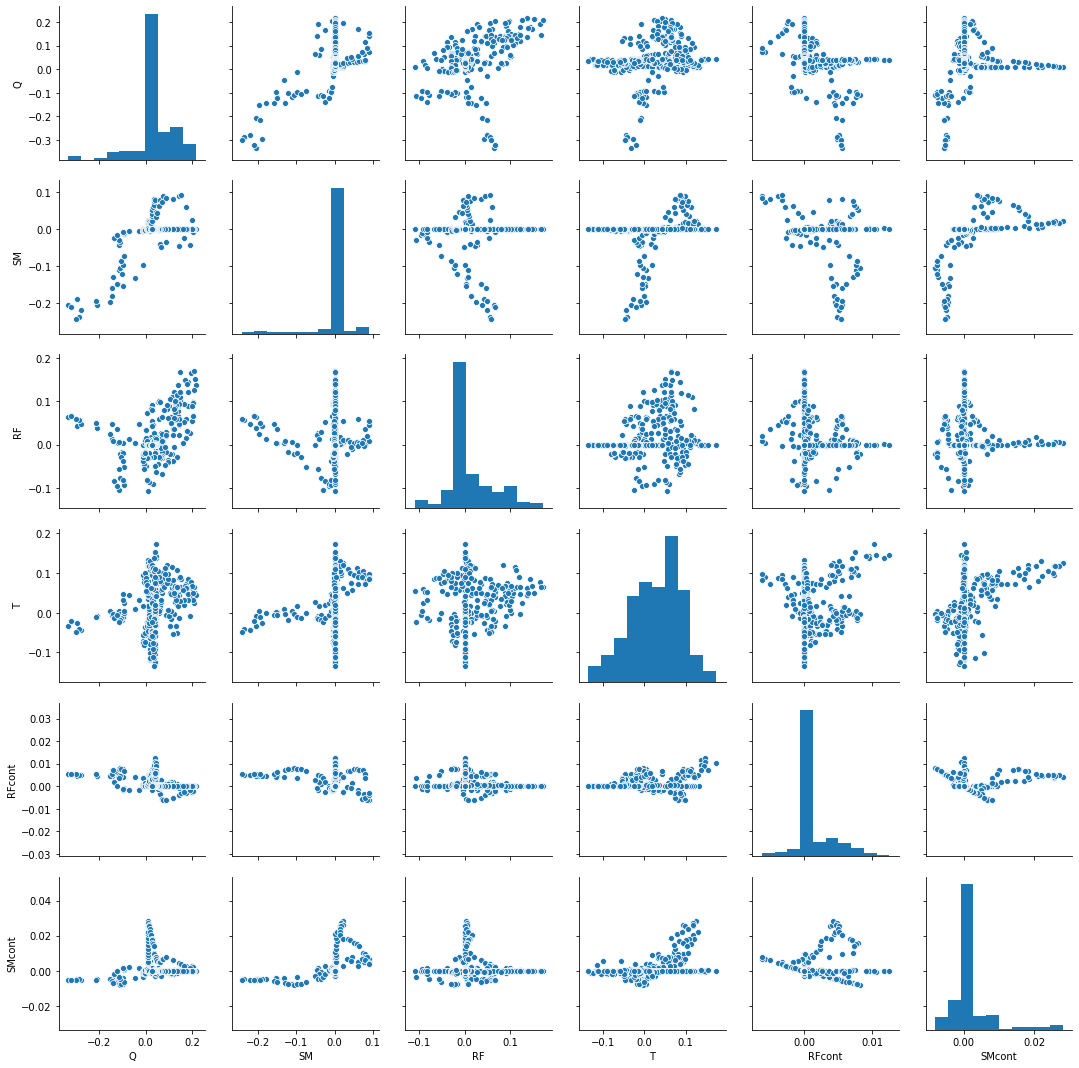

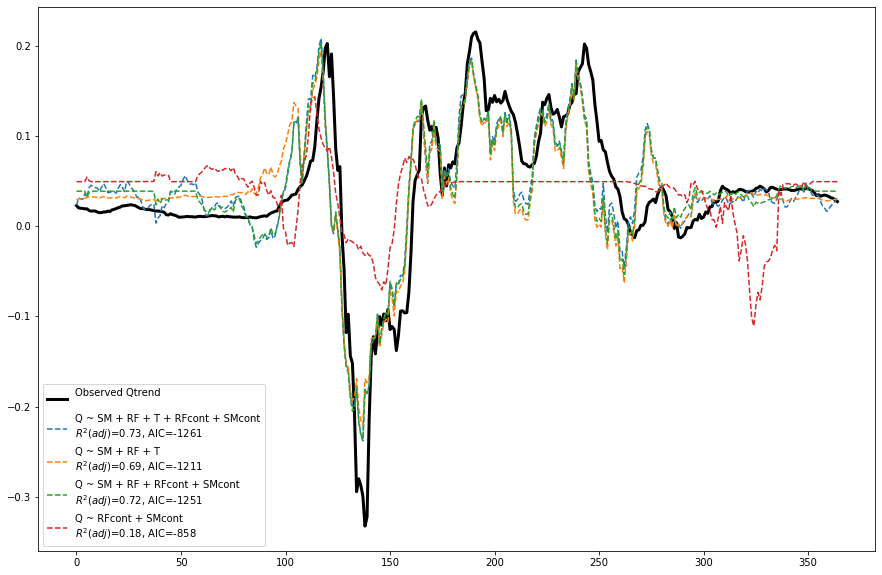

In [34]:
# linear model with two independent variables
data = pd.DataFrame({'Q': stream,
                     'SM': snow, 
                     'RF': rain,
                     "T":temp,
                     "RFcont":rainCont,
                     "SMcont":snowCont})

sns.pairplot(data)

plt.figure(figsize=(15,10))

formula = "Q ~ SM + RF + T + RFcont + SMcont"
model = ols(formula, data).fit()
#print(model.summary())
plt.plot(stream,color="k",linewidth=3,label="Observed Qtrend\n ")

plt.plot(model.predict(),
         "--",
         label=f"{formula}\n$R^2(adj)$={model.rsquared_adj:.2f}, AIC={model.aic:.0f}")
formula = "Q ~ SM + RF + T"
model = ols(formula, data).fit()
#print(model.summary())
plt.plot(model.predict(),
         "--",
         label=f"{formula}\n$R^2(adj)$={model.rsquared_adj:.2f}, AIC={model.aic:.0f}")

formula = "Q ~ SM + RF + RFcont + SMcont"
model = ols(formula, data).fit()
#print(model.summary())
plt.plot(model.predict(),
         "--",
         label=f"{formula}\n$R^2(adj)$={model.rsquared_adj:.2f}, AIC={model.aic:.0f}")

formula = "Q ~ RFcont + SMcont"
model = ols(formula, data).fit()
#print(model.summary())
plt.plot(model.predict(),
         "--",
         label=f"{formula}\n$R^2(adj)$={model.rsquared_adj:.2f}, AIC={model.aic:.0f}")

plt.legend()

                            OLS Regression Results                            
Dep. Variable:                      Q   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     303.1
Date:                Thu, 23 Jan 2020   Prob (F-statistic):           4.69e-78
Time:                        14:37:32   Log-Likelihood:                 574.48
No. Observations:                 365   AIC:                            -1143.
Df Residuals:                     362   BIC:                            -1131.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0318      0.003     11.288      0.0

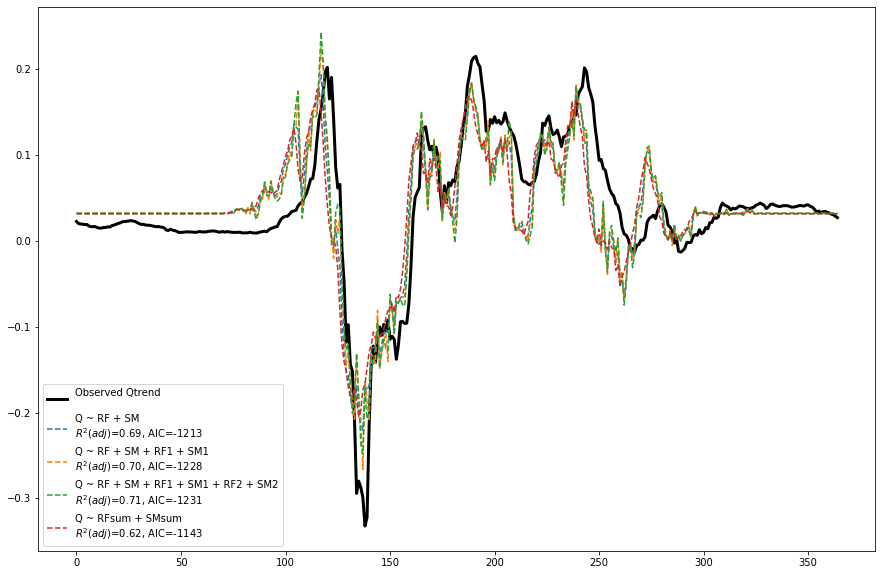

In [38]:
c = 20
snow = snowmelt[c,:]
rain = rainfall[c,:]
stream = streamflow[c,:]
temp = temperature[c,:]
rainCont = rainfallCont[c,:]
snowCont = snowmeltCont[c,:]
snow1 = np.roll(snowmelt,-1,axis=1)[c,:]
rain1 = np.roll(rainfall,-1,axis=1)[c,:]
snow2 = np.roll(snowmelt,-2,axis=1)[c,:]
rain2 = np.roll(rainfall,-2,axis=1)[c,:]

snowSum = snowmelt[c,:] + np.roll(snowmelt,-1,axis=1)[c,:] + np.roll(snowmelt,-2,axis=1)[c,:]
rainSum = rainfall[c,:] + np.roll(snowmelt,-1,axis=1)[c,:] + np.roll(rainfall,-2,axis=1)[c,:]

# linear model with two independent variables
data = pd.DataFrame({'Q': stream,
                     "SM":snow,
                     'SM1': snow1,
                     'SM2': snow2,
                     "SMsum":snowSum,
                     'RF': rain,
                     "RF1":rain1,
                     "RF2":rain2,
                     "RFsum":rainSum,
                     "T":temp,
                     "RFcont":rainCont,
                     "SMcont":snowCont})

plt.figure(figsize=(15,10))
plt.plot(stream,color="k",linewidth=3,label="Observed Qtrend\n ")

formula = "Q ~ RF + SM"
model = ols(formula, data).fit()
#print(model.summary())
plt.plot(model.predict(),
         "--",
         label=f"{formula}\n$R^2(adj)$={model.rsquared_adj:.2f}, AIC={model.aic:.0f}")

formula = "Q ~ RF + SM + RF1 + SM1"
model = ols(formula, data).fit()
#print(model.summary())
plt.plot(model.predict(),
         "--",
         label=f"{formula}\n$R^2(adj)$={model.rsquared_adj:.2f}, AIC={model.aic:.0f}")


formula = "Q ~ RF + SM + RF1 + SM1 + RF2 + SM2"
model = ols(formula, data).fit()
#print(model.summary())
plt.plot(model.predict(),
         "--",
         label=f"{formula}\n$R^2(adj)$={model.rsquared_adj:.2f}, AIC={model.aic:.0f}")

formula = "Q ~ RFsum + SMsum"
model = ols(formula, data).fit()
print(model.summary())
plt.plot(model.predict(),
         "--",
         label=f"{formula}\n$R^2(adj)$={model.rsquared_adj:.2f}, AIC={model.aic:.0f}")

plt.legend()

From evalutating this single catchment, it does not appear that adding the rainfall and snowmelt contributing proportion trends improves the model much. They predict very similar streamflow trends, and where there are larger differences, not including them appears to represent the streamflow better, e.g. around doy 100 and 300.

## Comparing different models for all catchments

In [28]:
def multiregressSingle(data,    
                       formulas = ["Q ~ SM + RF + T + RFcont + SMcont",
                                   "Q ~ SM + RF + T",
                                   "Q ~ SM + RF + RFcont + SMcont",
                                   "Q ~ RFcont + SMcont"]):
    """
    Performs OLS multiple regression on a dataset with a list of specified formulas.
    Returns dictionary with results (R²(adj) and AIC) for each model.
    
    Parameters
    ----------
    data: pandas.DataFrame
        contains data for all variables
    formulas: list
        list of model formulas for the multiple regression
        
    Returns
    -------
    res: dict
        containing R²(adj) and AIC for all models
    models: list
        list of ols model objects
    """
    
    res = {}
    models = []
    for formula in formulas:
        # fitting model
        model = ols(formula, data).fit()
        models.append(model)
        # saving criterions
        res[formula] = {}
        res[formula]["rsquared_adj"] = model.rsquared_adj
        res[formula]["aic"] = model.aic
    
    return res, models

def multiregressRegion(catchments,streamflow,snowmelt,rainfall,temperature,rainfallCont,snowmeltCont):
    """
    
    """
    result = {}
    for c in range(len(catchments)):
        # selecting data for single catchment
        snow = snowmelt[c,:]
        rain = rainfall[c,:]
        stream = streamflow[c,:]
        temp = temperature[c,:]
        rainCont = rainfallCont[c,:]
        snowCont = snowmeltCont[c,:]

        # multiregression
        data = pd.DataFrame({'Q': stream,
                             'SM': snow, 
                             'RF': rain,
                             "T":temp,
                             "RFcont":rainCont,
                             "SMcont":snowCont})
        
        result[catchments[c]] = multiregressSingle(data)[0]
    
    return result

In [29]:
def makeKwargs(region,period = "1983_2012"):
    # catchment list
    final = ht.openDict("Data/finalSelectionList.pkl")
    s = period.split("_")
    catchments = final[region]["-".join(s)]
    print(catchments)
    
    # data
    file = ht.findFiles(f"*Mag*snowmelt_*{region}*{period}*","Results/Daily")[0]
    print(file)
    snowmelt = np.load(file)

    file = ht.findFiles(f"*Mag*rainfall_*{region}*{period}*","Results/Daily")[0]
    print(file)
    rainfall = np.load(file)

    file = ht.findFiles(f"*Mag*stream*{region}*{period}*","Results/Daily")[0]
    print(file)
    streamflow = np.load(file)

    file = ht.findFiles(f"*Mag*temp*{region}*{period}*","Results/Daily")[0]
    print(file)
    temperature = np.load(file)

    file = ht.findFiles(f"*Mag*rainfallC*{region}*{period}*","Results/Daily")[0]
    print(file)
    rainfallCont = np.load(file)

    file = ht.findFiles(f"*Mag*snowmeltC*{region}*{period}*","Results/Daily")[0]
    print(file)
    snowmeltCont = np.load(file)

    kwargs = {"catchments":catchments,
              "streamflow":streamflow,
              "snowmelt":snowmelt,
              "rainfall":rainfall,
              "temperature":temperature,
              "rainfallCont":rainfallCont,
              "snowmeltCont":snowmeltCont}
    
    return kwargs

In [32]:
def getRandomColors(N,exludeWhite=True):
    allColors = list(mcolors.CSS4_COLORS.keys())
    if excludeWhite:
        allColors.remove("white")
    
    colors = []
    for n in range(N):
        colors.append(random.choice(allColors))
        
    return colors

[200291, 200268, 200013, 200290, 1200013, 200284, 200025, 1200197, 1200137, 1500079, 200032, 200614, 200145, 200129, 1200097, 1500049, 1200099, 1500053, 1600066, 1200207, 200011, 1200070, 200607, 1600122, 1600075, 1200171, 1200200, 1600010, 200028, 1200178, 31100460, 1600051, 200604, 200267, 31100004, 31100006, 1200113, 1200188, 200323, 1500021, 200280, 1600194, 200279, 200142, 200616, 800002, 600010, 1200193, 800006, 200633, 300022]
Results/Daily/trendMagnitudes_snowmelt_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfall_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_streamflow_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_temperature_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfallContRunoff_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_snowmeltContRunoff_ost_10dMA_1983_2012.npy
[7600005, 4600009, 7500022, 10900009, 8800004, 7300004, 9900017, 7300001, 7600011, 7600010, 7500028, 5000001, 7200005, 10900021, 10300040, 4600004, 4800005, 50

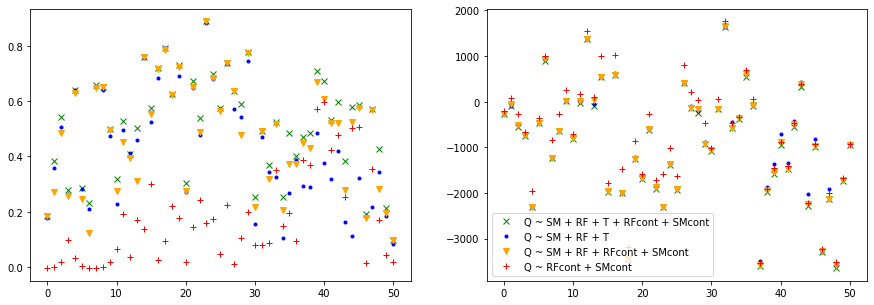

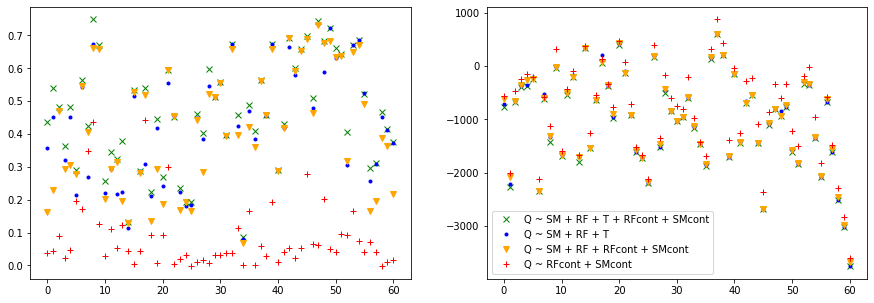

In [33]:
#N = len(res[list(res.keys())[0]].keys())
colors = itertools.cycle(["g","b","orange","r"])
markers = itertools.cycle(["x",".","v","+"])

region = "ost"
kwargs = makeKwargs(region)
res = multiregressRegion(**kwargs)
fig,ax = plt.subplots(figsize=(15,5),ncols=2)
for c in range(len(kwargs["catchments"])):
    sn = kwargs["catchments"][c]
    for formula in res[sn].keys():
        m = next(markers)
        col = next(colors)
        ax[0].plot(c,res[sn][formula]["rsquared_adj"],marker=m,color=col,label=formula)
        ax[1].plot(c,res[sn][formula]["aic"],marker=m,color=col,label=formula)

formulas=list(res[sn].keys())
legend_elements = [Line2D([0], [0], marker=next(markers), color=next(colors), label=formulas[0], linestyle=""),
                   Line2D([0], [0], marker=next(markers), color=next(colors), label=formulas[1], linestyle=""),
                   Line2D([0], [0], marker=next(markers), color=next(colors), label=formulas[2], linestyle=""),
                   Line2D([0], [0], marker=next(markers), color=next(colors), label=formulas[3], linestyle="")]
plt.legend(handles=legend_elements)

region = "vest"
kwargs = makeKwargs(region)
res = multiregressRegion(**kwargs)
fig,ax = plt.subplots(figsize=(15,5),ncols=2)
for c in range(len(kwargs["catchments"])):
    sn = kwargs["catchments"][c]
    for formula in res[sn].keys():
        m = next(markers)
        col = next(colors)
        ax[0].plot(c,res[sn][formula]["rsquared_adj"],marker=m,color=col,label=formula)
        ax[1].plot(c,res[sn][formula]["aic"],marker=m,color=col,label=formula)

formulas=list(res[sn].keys())
legend_elements = [Line2D([0], [0], marker=next(markers), color=next(colors), label=formulas[0], linestyle=""),
                   Line2D([0], [0], marker=next(markers), color=next(colors), label=formulas[1], linestyle=""),
                   Line2D([0], [0], marker=next(markers), color=next(colors), label=formulas[2], linestyle=""),
                   Line2D([0], [0], marker=next(markers), color=next(colors), label=formulas[3], linestyle="")]
plt.legend(handles=legend_elements)

What does it all mean??

# Results

## Two vs. three predictors

In [82]:
# Q ~ SM + RF
ost = pd.read_csv("Results/OLS/multiregression_QSMRF_ost_1983_2012.csv")
vest = pd.read_csv("Results/OLS/multiregression_QSMRF_vest_1983_2012.csv")
nord = pd.read_csv("Results/OLS/multiregression_QSMRF_nord_1983_2012.csv")
trond = pd.read_csv("Results/OLS/multiregression_QSMRF_trond_1983_2012.csv")
sor = pd.read_csv("Results/OLS/multiregression_QSMRF_sor_1983_2012.csv")
finn = pd.read_csv("Results/OLS/multiregression_QSMRF_finn_1983_2012.csv")

# Q ~ SM + RF + T
ost3 = pd.read_csv("Results/OLS/multiregression_QSMRFT_ost_1983_2012.csv")
vest3 = pd.read_csv("Results/OLS/multiregression_QSMRFT_vest_1983_2012.csv")
nord3 = pd.read_csv("Results/OLS/multiregression_QSMRFT_nord_1983_2012.csv")
trond3 = pd.read_csv("Results/OLS/multiregression_QSMRFT_trond_1983_2012.csv")
sor3 = pd.read_csv("Results/OLS/multiregression_QSMRFT_sor_1983_2012.csv")
finn3 = pd.read_csv("Results/OLS/multiregression_QSMRFT_finn_1983_2012.csv")

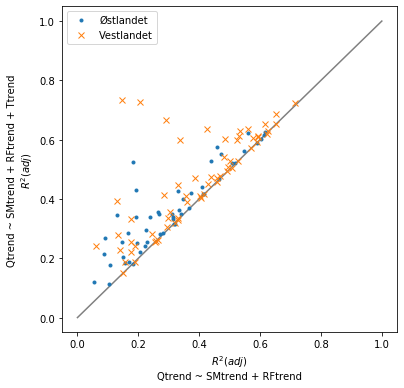

In [61]:
plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1],"grey")
plt.plot(ost.rsquared_adj,ost3.rsquared_adj,".",label="Østlandet")
plt.plot(vest.rsquared_adj,vest3.rsquared_adj,"x",label="Vestlandet")
plt.xlabel("$R^2(adj)$ \nQtrend ~ SMtrend + RFtrend")
plt.ylabel("Qtrend ~ SMtrend + RFtrend + Ttrend\n$R^2(adj)$")
plt.legend()
plt.savefig("Plots/1983_2012/OLS/QSMRFTvsQSMRF.png",dpi=300,bbox_inches='tight')

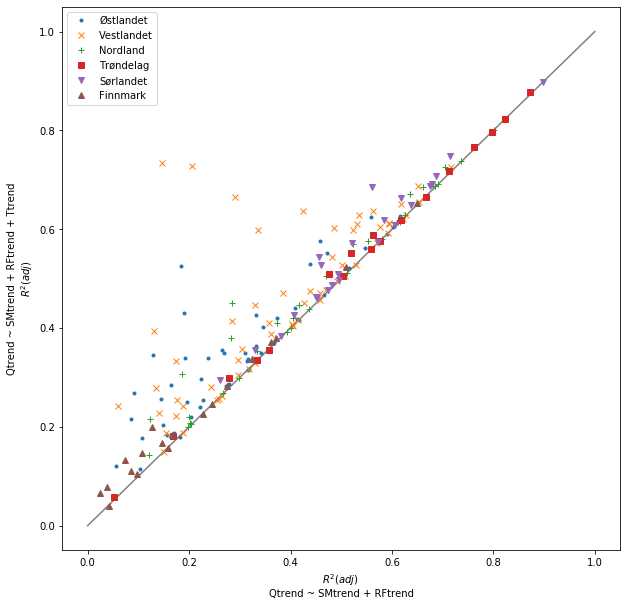

In [131]:
plt.figure(figsize=(10,10))
plt.plot([0,1],[0,1],"grey")
plt.plot(ost.rsquared_adj,ost3.rsquared_adj,".",label="Østlandet")
plt.plot(vest.rsquared_adj,vest3.rsquared_adj,"x",label="Vestlandet")
plt.plot(nord.rsquared_adj,nord3.rsquared_adj,"+",label="Nordland")
plt.plot(trond.rsquared_adj,trond3.rsquared_adj,"s",label="Trøndelag")
plt.plot(sor.rsquared_adj,sor3.rsquared_adj,"v",label="Sørlandet")
plt.plot(finn.rsquared_adj,finn3.rsquared_adj,"^",label="Finnmark")
plt.xlabel("$R^2(adj)$ \nQtrend ~ SMtrend + RFtrend")
plt.ylabel("Qtrend ~ SMtrend + RFtrend + Ttrend\n$R^2(adj)$")
plt.legend()

Adding temperature trend as a independent variable (predictor) improves the fit in catchments where the $R^2(adj)$ was below 0.5 with only snowmelt and rainfall trends as independent variables. But it doesn't change the fit where it was already good. 

The blocks below contains code to plot further differences between two and three independent variables. They can be activated by commenting out 
    
    plt.close()

In [38]:
kwargs = {"grid":False,
          "alpha":0.6,
          "range":(0,1),
          "bins":10}

ost.rsquared_adj.hist(label="SM+RF",**kwargs)
ost3.rsquared_adj.hist(label="SM+RF+T",**kwargs)
plt.title("Ostlandet")
plt.xlabel("$R^2(adj)$")
plt.legend()
plt.close()

plt.figure()
vest.rsquared_adj.hist(label="SM+RF",**kwargs)
vest3.rsquared_adj.hist(label="SM+RF+T",**kwargs)
plt.title("Vestlandet")
plt.xlabel("$R^2(adj)$")
plt.legend()
plt.close()

In [39]:
ost.intercept.hist(alpha=0.8,grid=False,bins=13,range=(-0.3,1),label="SM+RF")
ost3.intercept.hist(alpha=0.5,grid=False,bins=13,range=(-0.3,1),label="SM+RF+T")
plt.title("Ostlandet")
plt.xlabel("Intercept [$m^3s^{-1}\ yr^{-1}$]")
plt.legend()
plt.close()

plt.figure()
vest.intercept.hist(alpha=0.8,grid=False,bins=13,range=(-0.3,1),label="SM+RF")
vest3.intercept.hist(alpha=0.5,grid=False,bins=13,range=(-0.3,1),label="SM+RF+T")
plt.title("Vestlandet")
plt.xlabel("Intercept [$m^3s^{-1}\ yr^{-1}$]")
plt.legend()
plt.close()

In [40]:
ost.x1_snow.hist(alpha=0.8,grid=False,range=(-5,70),label="SM+RF")
ost3.x1_snow.hist(alpha=0.5,grid=False,range=(-5,70),label="SM+RF+T")
plt.title("Ostlandet")
plt.xlabel("Snowmelt trend parameter")
plt.legend()
plt.close()

plt.figure()
vest.x1_snow.hist(alpha=0.8,grid=False,range=(-1,12),label="SM+RF")
vest3.x1_snow.hist(alpha=0.5,grid=False,range=(-1,12),label="SM+RF+T")
plt.title("Vestlandet")
plt.xlabel("Snowmelt trend parameter")
plt.legend()
plt.close()

In [41]:
kwargs = {"grid":False,
          "alpha":0.6,
          "range":(5,35),
          "bins":12}
ost.x2_rain.hist(label="SM+RF",**kwargs)
ost3.x2_rain.hist(label="SM+RF+T",**kwargs)
plt.title("Ostlandet")
plt.xlabel("Rainfall trend parameter")
plt.legend()
plt.close()

plt.figure()
kwargs = {"grid":False,
          "alpha":0.6,
          "range":(-1,6),
          "bins":14}
vest.x2_rain.hist(label="SM+RF",**kwargs)
vest3.x2_rain.hist(label="SM+RF+T",**kwargs)
plt.title("Vestlandet")
plt.xlabel("Rainfall trend parameter")
plt.legend()
plt.close()

In [42]:
kwargs = {"grid":False}
ost3.x3_temp.hist(**kwargs)
plt.close()

plt.figure()
vest3.x3_temp.hist(**kwargs)
plt.close()

## Evaluate by season

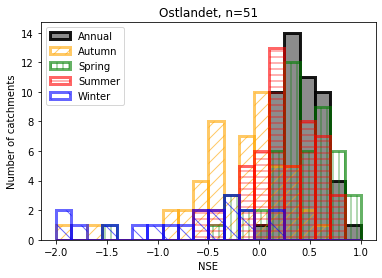

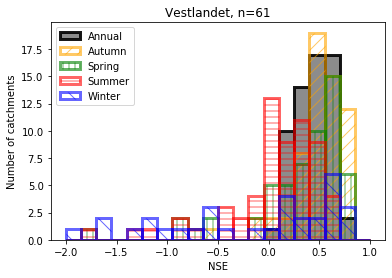

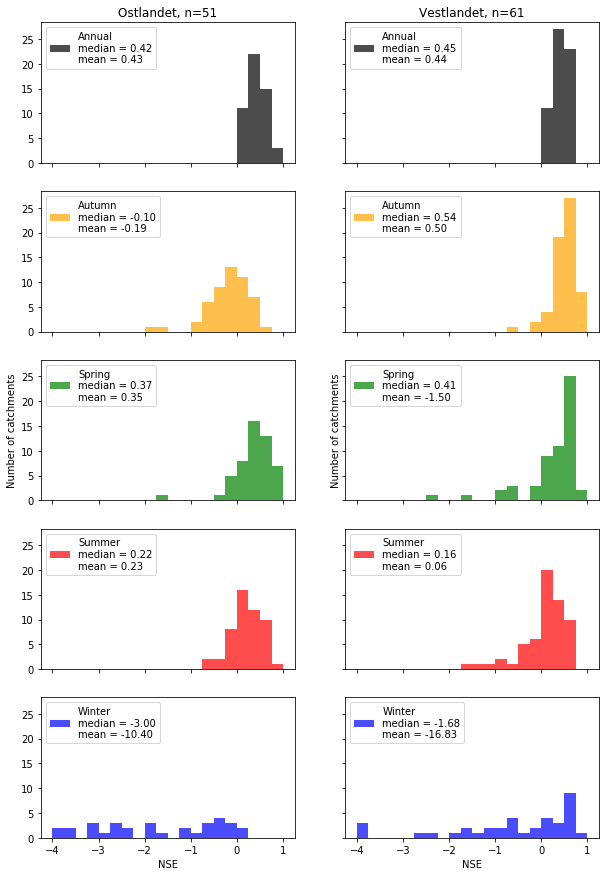

In [61]:
color = itertools.cycle(("k","orange","g","r","b"))
line = itertools.cycle(("-","--","-."))
hatch = itertools.cycle(("//", "||", '--', '\\'))
title = ["Ostlandet, n=51","Vestlandet, n=61"]

kwargs = {"grid":False,
          "alpha":0.9,
          "range":(-2,1),
          "bins":20,
          "linewidth":3,
          "fc":"grey"}

ost3.nse.hist(**kwargs,label="Annual",ec=next(color))
kwargs.update({"alpha":0.6,"fc":"None"})
ost3.nse_autumn.hist(**kwargs,label="Autumn",ec=next(color),hatch=next(hatch))
ost3.nse_spring.hist(**kwargs,label="Spring",ec=next(color),hatch=next(hatch))
ost3.nse_summer.hist(**kwargs,label="Summer",ec=next(color),hatch=next(hatch))
ost3.nse_winter.hist(**kwargs,label="Winter",ec=next(color),hatch=next(hatch))
plt.legend()
plt.title(title[0])
plt.ylabel("Number of catchments")
plt.xlabel("NSE")

kwargs = {"grid":False,
          "alpha":0.9,
          "range":(-2,1),
          "bins":20,
          "linewidth":3,
          "fc":"grey"}

plt.figure()
vest3.nse.hist(**kwargs,label="Annual",ec=next(color))
kwargs.update({"alpha":0.6,"fc":"None"})
vest3.nse_autumn.hist(**kwargs,label="Autumn",ec=next(color),hatch=next(hatch))
vest3.nse_spring.hist(**kwargs,label="Spring",ec=next(color),hatch=next(hatch))
vest3.nse_summer.hist(**kwargs,label="Summer",ec=next(color),hatch=next(hatch))
vest3.nse_winter.hist(**kwargs,label="Winter",ec=next(color),hatch=next(hatch))
plt.legend()
plt.title(title[1])
plt.ylabel("Number of catchments")
plt.xlabel("NSE")


kwargs = {"grid":False,
          "range":(-4,1),
          "bins":20,
          "alpha":0.7,
          "linewidth":3}

fig,ax = plt.subplots(nrows=5,ncols=2,figsize=(10,15),sharey=True,sharex=True)
dfs = [ost3,vest3]
for i in range(2):
    df = dfs[i]
    df.nse.hist(ax=ax[0,i],
                **kwargs,
                label=f"Annual\nmedian = {df.nse.median():.2}\nmean = {df.nse.mean():.2f}",
                fc = next(color))
    df.nse_autumn.hist(ax=ax[1,i],
                       **kwargs,
                       label=f"Autumn\nmedian = {df.nse_autumn.median():.2f}\nmean = {df.nse_autumn.mean():.2f}",
                       fc = next(color))
    df.nse_spring.hist(ax=ax[2,i],
                       **kwargs,
                       label=f"Spring\nmedian = {df.nse_spring.median():.2f}\nmean = {df.nse_spring.mean():.2f}",
                       fc = next(color))
    df.nse_summer.hist(ax=ax[3,i],
                       **kwargs,
                       label=f"Summer\nmedian = {df.nse_summer.median():.2f}\nmean = {df.nse_summer.mean():.2f}",
                       fc = next(color))
    df.nse_winter.hist(ax=ax[4,i],
                       **kwargs,
                       label=f"Winter\nmedian = {df.nse_winter.median():.2f}\nmean = {df.nse_winter.mean():.2f}",
                       fc = next(color))
    ax[0,i].set_title(title[i])
    ax[2,i].set_ylabel("Number of catchments")
    ax[4,i].set_xlabel("NSE")
    ax[0,i].legend(loc="upper left")
    ax[1,i].legend(loc="upper left")
    ax[2,i].legend(loc="upper left")
    ax[3,i].legend(loc="upper left")
    ax[4,i].legend(loc="upper left")

## Comparing results with catchment parameters

In [44]:
meta.columns

Index(['snumber', 'regine', 'main', 'name', 'stnr', 'start.yr', 'end.yr',
       'missing.yr', 'areal', 'altitude', 'utm.e', 'runoff.region', 'lon',
       'lat', 'AREAL_NOR', 'GRAD_FELT', 'GRAD_ELV', 'HEIGHT_MIN', 'HEIGHT_50',
       'HEIGHT_MAX', 'JORDBRUKPR', 'MYRPRO', 'SKOGPRO', 'BREPRO', 'SJOPRO',
       'SNAUFJPRO'],
      dtype='object')

In [45]:
def plotOLScorrelations(reg,catchments,region,period,addTemp=False,save=True):
    fig,ax = plt.subplots(nrows=4,ncols=3,figsize=(10,10))
    
    r2 = []
    gradfelt = []
    area = []
    altmin = []
    altmed = []
    altmax = []
    bre = []
    skog = []
    myr = []
    snau = []
    lat = []
    lon = []
    for c in catchments:
        r2.append(float(reg[reg.snumber==c].rsquared_adj))
        gradfelt.append(float(meta[meta.snumber==c].GRAD_FELT))
        area.append(float(meta[meta.snumber==c].areal))
        altmin.append(float(meta[meta.snumber==c].HEIGHT_MIN))
        altmed.append(float(meta[meta.snumber==c].HEIGHT_50))
        altmax.append(float(meta[meta.snumber==c].HEIGHT_MAX))
        bre.append(float(meta[meta.snumber==c].BREPRO))
        skog.append(float(meta[meta.snumber==c].SKOGPRO))
        myr.append(float(meta[meta.snumber==c].MYRPRO))
        snau.append(float(meta[meta.snumber==c].SNAUFJPRO))
        lat.append(float(meta[meta.snumber==c].lat))
        lon.append(float(meta[meta.snumber==c].lon))
    
    r2 = np.array(r2)
    gradfelt = np.array(gradfelt)
    area = np.array(area)
    altmin = np.array(altmin)
    altmed = np.array(altmed)
    altmax = np.array(altmax)
    altdiff = altmax-altmin
    bre = np.array(bre)
    skog = np.array(skog)
    myr = np.array(myr)
    snau = np.array(snau)
    lat = np.array(lat)
    lon = np.array(lon)
    
    # row 1
    ax[0][0].hist(reg.rsquared_adj,range=(0,1),bins=10)
    ax[0][0].set_xlabel("$R^2(adj)$")
    ax[0][0].set_ylabel("No. of catchments")
    ax[0][0].set_title(f"n = {reg.rsquared_adj.shape[0]}")
    
    ax[0][1].plot(gradfelt,r2,"kx")
    ax[0][1].set_xlabel("Catchment GRAD_FELT")
    ax[0][1].set_ylabel("$R^2(adj)$")
    x = gradfelt
    mask = np.isfinite(x)
    r = stats.pearsonr(x[mask],r2[mask])[0]
    ax[0][1].set_title(f"r = {r:.2f}")
        
    ax[0][2].plot(area,r2,"kx")
    ax[0][2].set_xlabel("Catchment area in $km^2$")
    ax[0][2].set_ylabel("$R^2(adj)$")
    x = area
    mask = np.isfinite(x)
    r = stats.pearsonr(x[mask],r2[mask])[0]
    ax[0][2].set_title(f"r = {r:.2f}")
    
    # row 2
    ax[1][0].plot(altmin,r2,"kv")
    ax[1][0].set_xlabel("Catchment min altitude")
    ax[1][0].set_ylabel("$R^2(adj)$")
    x = altmin
    mask = np.isfinite(x)
    r = stats.pearsonr(x[mask],r2[mask])[0]
    ax[1][0].set_title(f"r = {r:.2f}")

    ax[1][1].plot(altmed,r2,"k.")
    ax[1][1].set_xlabel("Catchment median altitude")
    ax[1][1].set_ylabel("$R^2(adj)$")
    x = altmed
    mask = np.isfinite(x)
    r = stats.pearsonr(x[mask],r2[mask])[0]
    ax[1][1].set_title(f"r = {r:.2f}")

    ax[1][2].plot(altmax,r2,"k^")
    ax[1][2].set_xlabel("Catchment max altitude")
    ax[1][2].set_ylabel("$R^2(adj)$")
    x = altmax
    mask = np.isfinite(x)
    r = stats.pearsonr(x[mask],r2[mask])[0]
    ax[1][2].set_title(f"r = {r:.2f}")
    
    # row 3
    ax[2][0].plot(bre,r2,"bx")
    ax[2][0].set_xlabel("Catchment glaciation in %")
    ax[2][0].set_ylabel("$R^2(adj)$")
    x = bre
    mask = np.isfinite(x)
    r = stats.pearsonr(x[mask],r2[mask])[0]
    ax[2][0].set_title(f"r = {r:.2f}")
    
    ax[2][1].plot(skog,r2,"gx")
    ax[2][1].set_xlabel("Catchment forest cover in %")
    ax[2][1].set_ylabel("$R^2(adj)$")
    x = skog
    mask = np.isfinite(x)
    r = stats.pearsonr(x[mask],r2[mask])[0]
    ax[2][1].set_title(f"r = {r:.2f}")

    ax[2][2].plot(myr,r2,"x",color="brown")
    ax[2][2].set_xlabel("Catchment wetland in %")
    ax[2][2].set_ylabel("$R^2(adj)$")
    x = myr
    mask = np.isfinite(x)
    r = stats.pearsonr(x[mask],r2[mask])[0]
    ax[2][2].set_title(f"r = {r:.2f}")
    
    #ax[2][2].plot(altdiff,r2,"o",color="pink")
    #ax[2][2].set_xlabel("Altitude range")
    #ax[2][2].set_ylabel("$R^2(adj)$")
    #x = altdiff
    #mask = np.isfinite(x)
    #r = stats.pearsonr(x[mask],r2[mask])[0]
    #ax[2][2].set_title(f"r = {r:.2f}")
    
    # row 3
    ax[3][0].plot(snau,r2,"x",color="gold")
    ax[3][0].set_xlabel("Catchment alpine tundra")
    ax[3][0].set_ylabel("$R^2(adj)$")
    x = snau
    mask = np.isfinite(x)
    r = stats.pearsonr(x[mask],r2[mask])[0]
    ax[3][0].set_title(f"r = {r:.2f}")

    ax[3][1].plot(lat,r2,"kx")
    ax[3][1].set_xlabel("Latitude")
    ax[3][1].set_ylabel("$R^2(adj)$")
    x = lat
    mask = np.isfinite(x)
    r = stats.pearsonr(x[mask],r2[mask])[0]
    ax[3][1].set_title(f"r = {r:.2f}")

    ax[3][2].plot(lon,r2,"kx")
    ax[3][2].set_xlabel("Longitude")
    ax[3][2].set_ylabel("$R^2(adj)$")
    x = lon
    mask = np.isfinite(x)
    r = stats.pearsonr(x[mask],r2[mask])[0]
    ax[3][2].set_title(f"r = {r:.2f}")
    
    if addTemp:
        header = f"Results from mulitple linear regression\n{region}, {period}\nStreamflow trend ~ snowmelt trend + rainfall trend + temperature trend"
    else:
        header = f"Results from mulitple linear regression\n{region}, {period}\nStreamflow trend ~ snowmelt trend + rainfall trend"
    
    fig.suptitle(header,y=1.05)
    plt.tight_layout()
    
    a = period.split("-")
    period = "_".join(a)
    if save:
        if addTemp:
            plt.savefig(f"Plots/{period}/OLS/correlationWithFeltparam_QSMRFT_{region}_{period}.png",dpi=400,bbox_inches='tight')
        else:
            plt.savefig(f"Plots/{period}/OLS/correlationWithFeltparam_QSMRF_{region}_{period}.png",dpi=400,bbox_inches='tight')

    return r2,gradfelt,area,altmin,altmed,altmax,bre,skog,myr

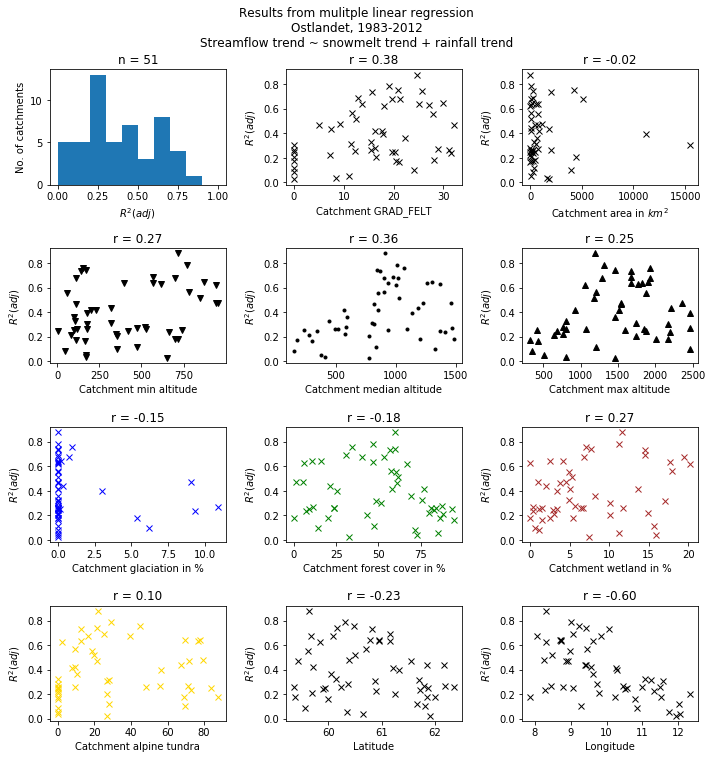

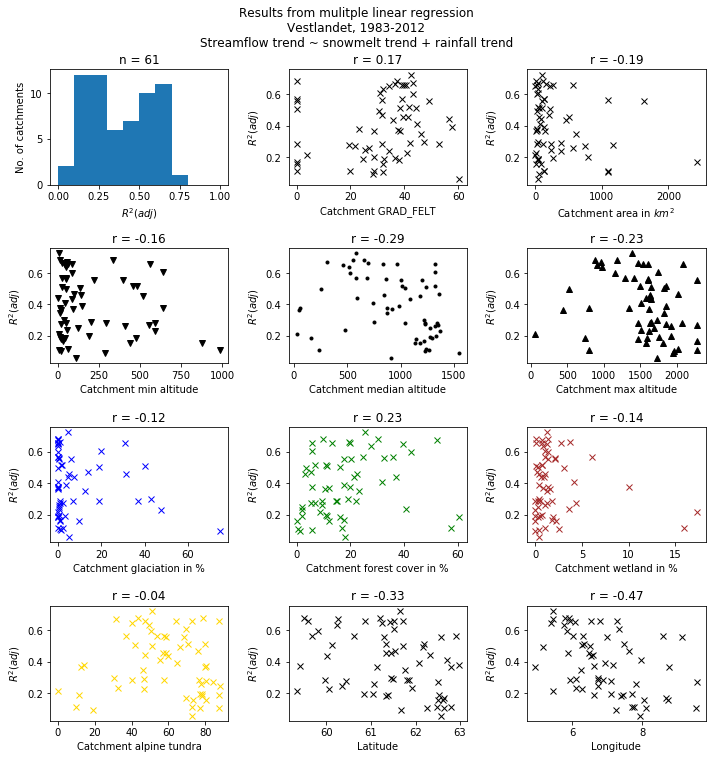

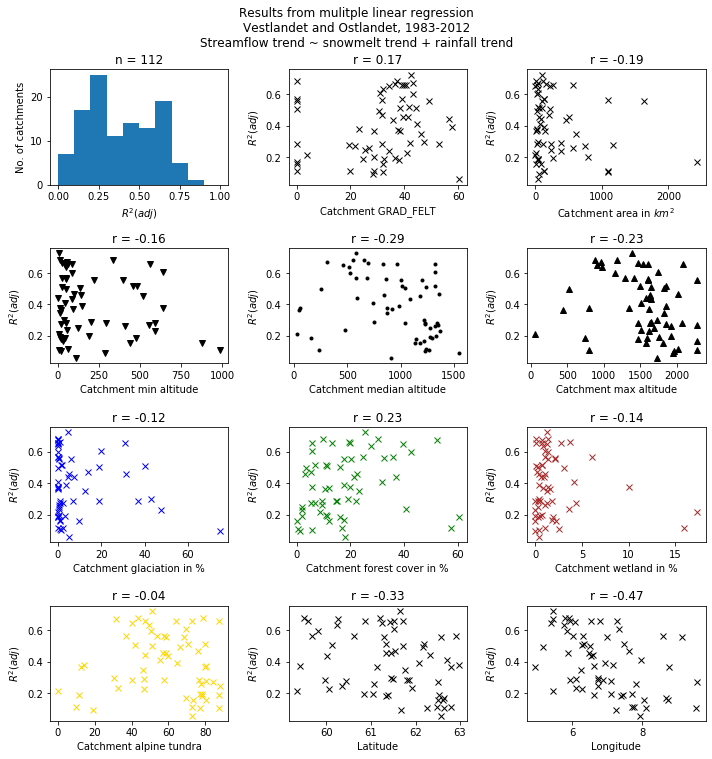

In [46]:
region = "ost"
period = "1983-2012"
catchments = final[region][period]
reg = pd.read_csv(f"Results/OLS/multiregression_QSMRF_{region}_1983_2012.csv")
plotOLScorrelations(reg,catchments,"Ostlandet",period)

region = "vest"
catchments = final[region][period]
reg = pd.read_csv(f"Results/OLS/multiregression_QSMRF_{region}_1983_2012.csv")
plotOLScorrelations(reg,catchments,"Vestlandet",period)

vest = pd.read_csv(f"Results/OLS/multiregression_QSMRF_vest_1983_2012.csv")
ost = pd.read_csv(f"Results/OLS/multiregression_QSMRF_ost_1983_2012.csv")
reg = pd.concat([vest,ost],ignore_index=True)
plotOLScorrelations(reg,catchments,"Vestlandet and Ostlandet",period)

None

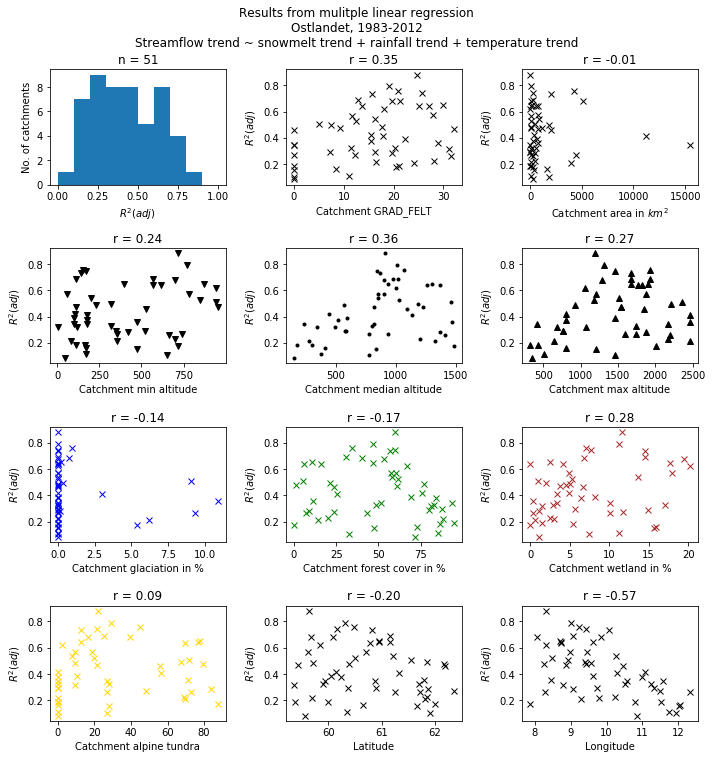

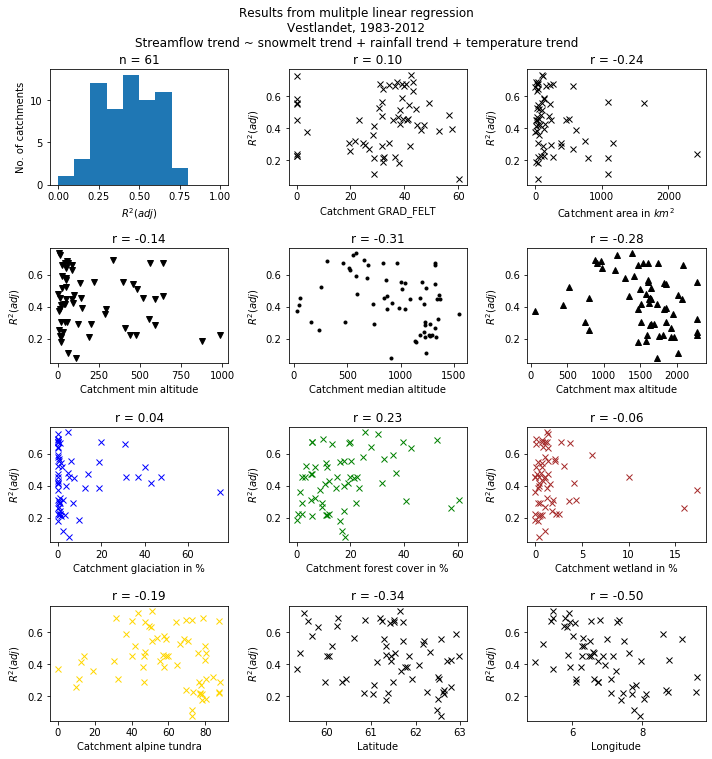

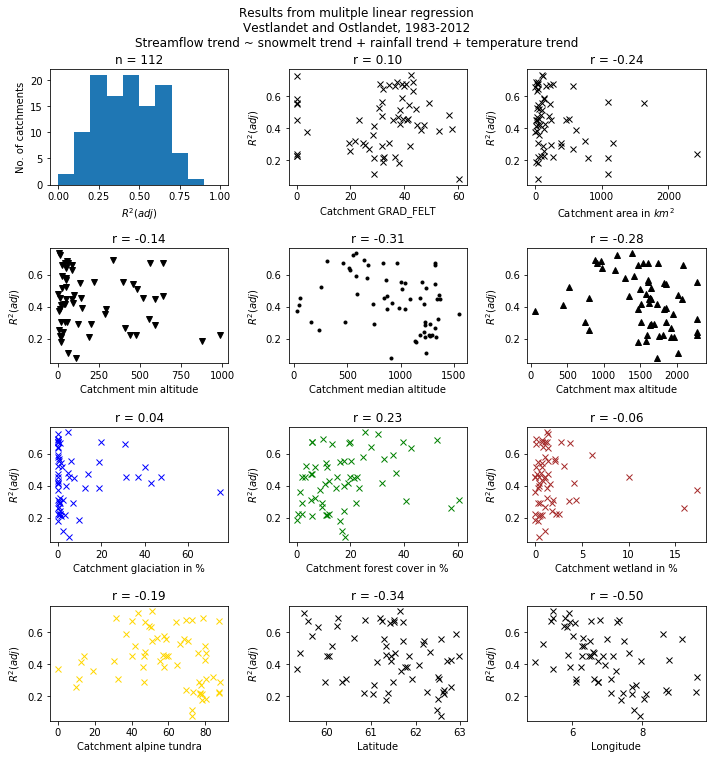

In [47]:
region = "ost"
period = "1983-2012"
catchments = final[region][period]
reg = pd.read_csv(f"Results/OLS/multiregression_QSMRFT_{region}_1983_2012.csv")
plotOLScorrelations(reg,catchments,"Ostlandet",period,addTemp=True)

region = "vest"
catchments = final[region][period]
reg = pd.read_csv(f"Results/OLS/multiregression_QSMRFT_{region}_1983_2012.csv")
plotOLScorrelations(reg,catchments,"Vestlandet",period,addTemp=True)

vest = pd.read_csv(f"Results/OLS/multiregression_QSMRFT_vest_1983_2012.csv")
ost = pd.read_csv(f"Results/OLS/multiregression_QSMRFT_ost_1983_2012.csv")
reg = pd.concat([vest,ost],ignore_index=True)
plotOLScorrelations(reg,catchments,"Vestlandet and Ostlandet",period,addTemp=True)

None

**Comments**
* Overall  $R^2(adj)$ appears NOT to be strongly correlated with a single particular parameter, that could explain why the regression works well for some catchment and not so well for others

* However, some catchment parameters, e.g. glaciation, wetland, are associated with some low $R^2(adj)$

* Geographical location (lat,lon) may also have an impact

* SUGGESTION: Look at catchments where the fit is particularly bad, e.g. $R^2(adj)<0.2$ separately to find out why

## Influence of geographical location

In [102]:
norge = gpd.read_file("Data/gis/Norge.shp")
regionLines = gpd.read_file("Data/gis/Grense_Avrenningsregioner.shp")
stations = gpd.read_file("Data/gis/Gauging_Stations.shp")

# Q ~ SM + RF
ost = pd.read_csv("Results/OLS/multiregression_QSMRF_ost_1983_2012.csv")
vest = pd.read_csv("Results/OLS/multiregression_QSMRF_vest_1983_2012.csv")
nord = pd.read_csv("Results/OLS/multiregression_QSMRF_nord_1983_2012.csv")
trond = pd.read_csv("Results/OLS/multiregression_QSMRF_trond_1983_2012.csv")
sor = pd.read_csv("Results/OLS/multiregression_QSMRF_sor_1983_2012.csv")
finn = pd.read_csv("Results/OLS/multiregression_QSMRF_finn_1983_2012.csv")

# Q ~ SM + RF + T
ost3 = pd.read_csv("Results/OLS/multiregression_QSMRFT_ost_1983_2012.csv")
vest3 = pd.read_csv("Results/OLS/multiregression_QSMRFT_vest_1983_2012.csv")
nord3 = pd.read_csv("Results/OLS/multiregression_QSMRFT_nord_1983_2012.csv")
trond3 = pd.read_csv("Results/OLS/multiregression_QSMRFT_trond_1983_2012.csv")
sor3 = pd.read_csv("Results/OLS/multiregression_QSMRFT_sor_1983_2012.csv")
finn3 = pd.read_csv("Results/OLS/multiregression_QSMRFT_finn_1983_2012.csv")

In [19]:
def getStations(df,qual = "all"):
    """
    Extracts station locations for a given dataframe.
    Optional to filter by r-squared using "qual" parameter.
    
    Parameters
    ----------
    df: pandas.DataFrame
    qual: int,str 
        default: "all"
            all stations in df are returned
        int {0,1,2,3,4}
            if integer between 0 and 4, the stations are filtered according to r-squared 
            where 0 is worst and 4 best quality
    
    Returns
    -------
    geopandas.geodataframe.GeoDataFrame
        containing specified catchments
    """
    norge = gpd.read_file("Data/gis/Norge.shp")
    regionLines = gpd.read_file("Data/gis/Grense_Avrenningsregioner.shp")
    stations = gpd.read_file("Data/gis/Gauging_Stations.shp")
    
    filters = [(df.rsquared_adj>=0) & (df.rsquared_adj<0.2),
               (df.rsquared_adj>=0.2) & (df.rsquared_adj<0.4),
               (df.rsquared_adj>=0.4) & (df.rsquared_adj<0.6),
               (df.rsquared_adj>=0.6) & (df.rsquared_adj<0.8),
               (df.rsquared_adj>=0.8) & (df.rsquared_adj<=1)]
    
    if qual=="all":
        sel = []
        for sn in df.snumber:
            sel.append(".".join(str(i) for i in ht.snumber_to_stnr(sn)))
    else:
        sel = []
        filt = filters[qual]
        for sn in df[filt].snumber:
            sel.append(".".join(str(i) for i in ht.snumber_to_stnr(sn)))

    mask = stations.STASJON_NR.isin(sel)
    
    return stations[mask]

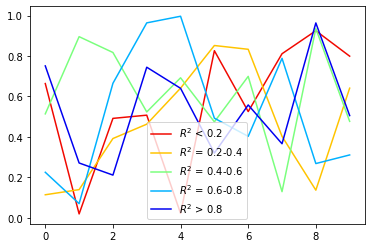

In [20]:
# quality colors to use in map
cmap = plt.cm.get_cmap("jet_r")

qcol = []
for i in np.linspace(0.1,0.9,5):
    qcol.append(cmap(i))

qlabel = ["$R^2$ < 0.2",
          "$R^2$ = 0.2-0.4",
          "$R^2$ = 0.4-0.6",
          "$R^2$ = 0.6-0.8",
          "$R^2$ > 0.8"]
    
for i in range(5):
    y = np.random.rand(10)
    plt.plot(y, color=qcol[i],label=qlabel[i])
plt.legend()

In [124]:
def plotRegressionQualityLocation(results):
    """
    Plots r-squared colorcoded on a map.
    
    results: list
        containing the results dataframes from multiple regression
    """
    # quality colors to use in map
    cmap = plt.cm.get_cmap("jet_r")

    qcol = []
    for i in np.linspace(0.1,0.9,5):
        qcol.append(cmap(i))

    qlabel = ["$R^2$ < 0.2",
              "$R^2$ = 0.2-0.4",
              "$R^2$ = 0.4-0.6",
              "$R^2$ = 0.6-0.8",
              "$R^2$ > 0.8"]
    
    # plotting and saving map

    if len(results)>2:
        fig,ax = plt.subplots(figsize=(7,13))
    else:
        fig,ax = plt.subplots(figsize=(7,7))
        
    norge.plot(ax=ax,color="white", edgecolor="lightgrey")
    regionLines.plot(ax=ax,color="darksalmon",label="Runoff region border")

    for qual in np.arange(5):
        for i,reg in enumerate(results):
            stationSel = getStations(reg,qual)
            stationSel.plot(ax=ax,marker="o",markersize=60,color=qcol[qual],label=qlabel[qual],alpha=.6)

    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    plt.setp(ax.get_xticklines(), visible=False)
    plt.setp(ax.get_yticklines(), visible=False)
    plt.setp(ax.spines.values(), visible=False)

    if len(results)<3:
        plt.ylim(6450000,7300000)
        plt.xlim(-100000,400000)
    kwargs = {"marker":"o",
              "color":"w",
              "markersize":10,
              "alpha":0.6}
    custom_lines = [Line2D([0], [0], markerfacecolor=qcol[0], **kwargs),
                    Line2D([0], [0], markerfacecolor=qcol[1], **kwargs),
                    Line2D([0], [0], markerfacecolor=qcol[2], **kwargs),
                    Line2D([0], [0], markerfacecolor=qcol[3], **kwargs),
                    Line2D([0], [0], markerfacecolor=qcol[4], **kwargs)]
    plt.legend(custom_lines,qlabel,loc="upper left")

### Maps

#### Østlandet and Vestlandet

/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


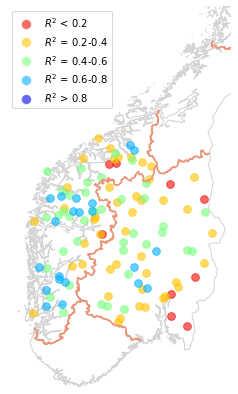

In [132]:
plotRegressionQualityLocation([ost3,vest3])
plt.savefig("Plots/1983_2012/OLS/map_ostvest_multiregression_QSMRFT_1983_2012.png",dpi=400,bbox_inches='tight')

/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


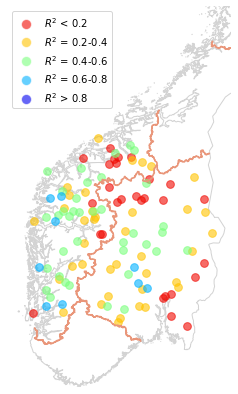

In [133]:
plotRegressionQualityLocation([ost,vest])
plt.savefig("Plots/1983_2012/OLS/map_ostvest_multiregression_QSMRF_1983_2012.png",dpi=400,bbox_inches='tight')

#### Norway

/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


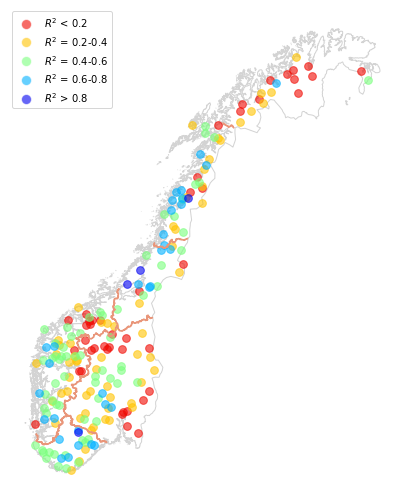

In [134]:
plotRegressionQualityLocation([ost,vest,trond,nord,sor,finn])
plt.savefig("Plots/1983_2012/OLS/map_multiregression_QSMRF_1983_2012.png",dpi=400,bbox_inches='tight')

/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


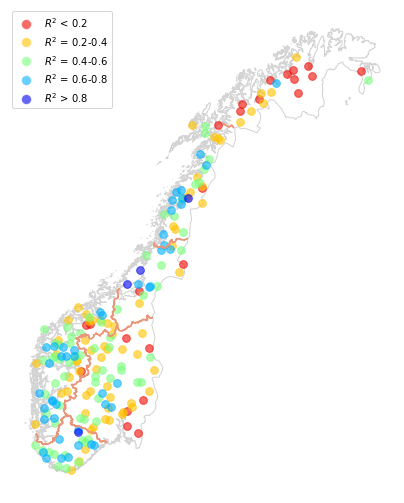

In [135]:
plotRegressionQualityLocation([ost3,vest3,trond3,nord3,finn3,sor3])
plt.savefig("Plots/1983_2012/OLS/map_multiregression_QSMRFT_1983_2012.png",dpi=400,bbox_inches='tight')

### Taking a closer look at catchments with poor R² 

In [54]:
def getLocationsbySnumber(snumbers):
    """
    snumbers: list
    """
    sel = []
    for sn in snumbers:
        sel.append(".".join(str(i) for i in ht.snumber_to_stnr(sn)))
    mask = stations.STASJON_NR.isin(sel)
    return stations[mask]

#### Three independent variables

Catchments with R-squared<0.2: 12


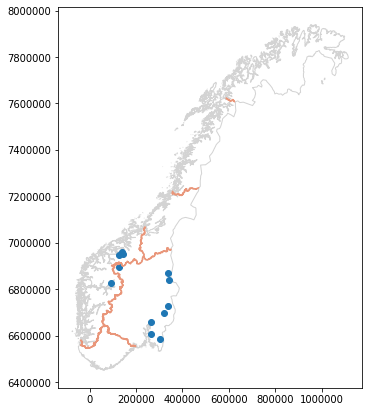

In [55]:
limit = 0.2
# 
poor = list(ost3[ost3.rsquared_adj<=limit].snumber)+ list(vest3[vest3.rsquared_adj<=limit].snumber)
print(f"Catchments with R-squared<{limit}: {len(poor)}")

fig,ax = plt.subplots(figsize=(7,7))
norge.plot(ax=ax,color="white", edgecolor="lightgrey")
regionLines.plot(ax=ax,color="darksalmon",label="Runoff region border")
getLocationsbySnumber(poor).plot(ax=ax)

In [56]:
poorParams = meta[meta.snumber.isin(poor)]
poorParams.iloc[:,14:]

,AREAL_NOR,GRAD_FELT,GRAD_ELV,HEIGHT_MIN,HEIGHT_50,HEIGHT_MAX,JORDBRUKPR,MYRPRO,SKOGPRO,BREPRO,SJOPRO,SNAUFJPRO
6,1288.281,8.42,4.77,170.0,411.0,807.0,2.20,15.93,72.75,0.00,1.84,0.00
14,262.270,20.56,29.31,717.0,1485.0,2006.0,0.01,0.00,0.07,5.40,6.23,87.42
20,48.380,11.03,15.94,171.0,376.0,510.0,0.15,11.31,85.14,0.00,3.10,0.00
21,87.130,0.00,6.42,111.0,178.0,323.0,4.12,5.39,86.26,0.00,3.72,0.00
22,299.290,0.00,3.29,47.0,153.0,347.0,20.02,1.19,71.73,0.00,2.39,0.00
23,7.030,21.04,43.68,165.0,300.0,435.0,0.00,1.56,94.47,0.00,2.84,0.00
100,45.920,38.13,83.55,17.0,1148.0,1467.0,0.02,0.30,16.20,0.00,0.98,78.22
129,44.400,60.23,99.36,110.0,912.0,1724.0,0.38,0.38,18.18,5.25,2.00,72.75
130,1099.420,28.72,19.42,61.0,1241.0,2012.0,1.12,1.09,16.97,2.19,3.81,72.76
132,13.680,32.16,47.76,880.0,1132.0,1575.0,0.00,0.00,0.00,9.50,10.23,80.26


In [57]:
poorParams.iloc[:,14:][poorParams.SNAUFJPRO>70]

,AREAL_NOR,GRAD_FELT,GRAD_ELV,HEIGHT_MIN,HEIGHT_50,HEIGHT_MAX,JORDBRUKPR,MYRPRO,SKOGPRO,BREPRO,SJOPRO,SNAUFJPRO
14,262.27,20.56,29.31,717.0,1485.0,2006.0,0.01,0.00,0.07,5.40,6.23,87.42
100,45.92,38.13,83.55,17.0,1148.0,1467.0,0.02,0.30,16.20,0.00,0.98,78.22
129,44.40,60.23,99.36,110.0,912.0,1724.0,0.38,0.38,18.18,5.25,2.00,72.75
130,1099.42,28.72,19.42,61.0,1241.0,2012.0,1.12,1.09,16.97,2.19,3.81,72.76
132,13.68,32.16,47.76,880.0,1132.0,1575.0,0.00,0.00,0.00,9.50,10.23,80.26


In [58]:
poorParams.iloc[:,14:][poorParams.MYRPRO>10]

,AREAL_NOR,GRAD_FELT,GRAD_ELV,HEIGHT_MIN,HEIGHT_50,HEIGHT_MAX,JORDBRUKPR,MYRPRO,SKOGPRO,BREPRO,SJOPRO,SNAUFJPRO
6,1288.281,8.42,4.77,170.0,411.0,807.0,2.20,15.93,72.75,0.0,1.84,0.00
20,48.380,11.03,15.94,171.0,376.0,510.0,0.15,11.31,85.14,0.0,3.10,0.00
225,390.731,0.00,-999.00,472.0,837.0,1207.0,0.94,15.62,47.44,0.0,4.07,28.24


* Glaciation is relatively low
* Alpine tundra (SNAUFJPRO) is over 70 % for 5 of the catchments, these catchments are also at relatively high elevations. The same catchments generally also have low forest cover
* Where the alpine tundra is low, there are 3 catchments where the wetland part is relatively high
* Generally however, geographical location seems to play a more important role, especially the catchments furthest east. This could mean that there are some hydro-climatic factors that play an important role.

#### Two independent variables

Catchments with R-squared<0.2: 12


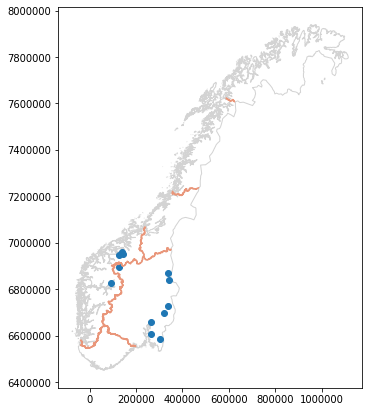

In [59]:
limit = 0.2
# 
poor = list(ost[ost.rsquared_adj<=limit].snumber)+ list(vest[vest.rsquared_adj<=limit].snumber)
print(f"Catchments with R-squared<{limit}: {len(poor)}")

fig,ax = plt.subplots(figsize=(7,7))
norge.plot(ax=ax,color="white", edgecolor="lightgrey")
regionLines.plot(ax=ax,color="darksalmon",label="Runoff region border")
getLocationsbySnumber(poor).plot(ax=ax)

In [60]:
poorParams = meta[meta.snumber.isin(poor)]
poorParams.iloc[:,14:]

,AREAL_NOR,GRAD_FELT,GRAD_ELV,HEIGHT_MIN,HEIGHT_50,HEIGHT_MAX,JORDBRUKPR,MYRPRO,SKOGPRO,BREPRO,SJOPRO,SNAUFJPRO
6,1288.281,8.42,4.77,170.0,411.0,807.0,2.20,15.93,72.75,0.00,1.84,0.00
14,262.270,20.56,29.31,717.0,1485.0,2006.0,0.01,0.00,0.07,5.40,6.23,87.42
20,48.380,11.03,15.94,171.0,376.0,510.0,0.15,11.31,85.14,0.00,3.10,0.00
21,87.130,0.00,6.42,111.0,178.0,323.0,4.12,5.39,86.26,0.00,3.72,0.00
22,299.290,0.00,3.29,47.0,153.0,347.0,20.02,1.19,71.73,0.00,2.39,0.00
23,7.030,21.04,43.68,165.0,300.0,435.0,0.00,1.56,94.47,0.00,2.84,0.00
100,45.920,38.13,83.55,17.0,1148.0,1467.0,0.02,0.30,16.20,0.00,0.98,78.22
129,44.400,60.23,99.36,110.0,912.0,1724.0,0.38,0.38,18.18,5.25,2.00,72.75
130,1099.420,28.72,19.42,61.0,1241.0,2012.0,1.12,1.09,16.97,2.19,3.81,72.76
132,13.680,32.16,47.76,880.0,1132.0,1575.0,0.00,0.00,0.00,9.50,10.23,80.26
